<a href="https://colab.research.google.com/github/Seif-Tarek/Siamese_Text_Similarity/blob/master/Siamese_TextSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"


--2020-05-09 23:52:27--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.44.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.44.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.5MB/s    in 98s     

2020-05-09 23:54:06 (16.0 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
import tensorflow as tf
import pandas as pd
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
from gensim.models import KeyedVectors

print(tf.__version__)


2.2.0-rc4


In [0]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
#x = word2vec.word_vec("test")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
sentence_obama = 'Obama speaks to the media in Illinois'.lower().split()
sentence_president = 'The president greets the press in Chicago'.lower().split()
word2vec.wmdistance(sentence_obama, sentence_president)

In [0]:
vec_size = word2vec.vector_size
vocab_size = 100000

# Create the embedding matrix where words are indexed alphabetically
embedding_mat = np.zeros(shape=(vocab_size, vec_size), dtype='int32')
for idx, word in enumerate(sorted(word2vec.vocab)):
  if idx >= vocab_size:
    break
  embedding_mat[idx] = word2vec.get_vector(word)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
pip install rarfile


     |████████████████████████████████| 122kB 9.4MB/s 
  Created wheel for rarfile: filename=rarfile-3.1-cp36-none-any.whl size=24908 sha256=7cd5c9b10d4a940500308a4247111346bc876fc0957ae4c94f19d70d79fc1cb5
  Stored in directory: /root/.cache/pip/wheels/23/3c/c8/0215b6a5079492eff3be3f545ae0b0c4a66734c35c9e444eac
Successfully built rarfile


In [0]:
import rarfile
rar_path = rarfile.RarFile('drive/My Drive/dataframe.rar')
csv_file_name = "export_dataframe.csv"
rar_file = rarfile.RarFile.open(rar_path, csv_file_name)

In [0]:
data = pd.read_csv(rar_file)


In [0]:
def split(dt):
  size = len(dt)
  train = dt[:32000,]
  val = dt[32000:,]
  test = dt[32000:,]
  return train,val,test

In [0]:
data = data.sample(frac=1)

train1 = data['articles'].astype('str')
train2 = data['abstracts'].astype('str')
labels = data['similarity']
print(train1.shape)


train1, val1, test1 = split(train1)
train2, val2, test2 = split(train2)
labels, val_label, test_label = split(labels)
print(train1.shape)
print(val2.shape)
print(test_label.shape)


(40000,)
(32000,)
(8000,)
(8000,)


In [0]:
max = 0
for x in train1:
  res = len(x.split()) 
  if max<res:
    max = res


In [0]:
vocab_size = 100000
embedding_dim = 300
max_length = max
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train1)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train1)
train1_padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(val1)
test1_padded = pad_sequences(testing_sequences,maxlen=max_length)

sequences = tokenizer.texts_to_sequences(train2)
train2_padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(val2)
test2_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100,input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2164, 100)         10000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 2164, 128)         84480     
_________________________________________________________________
dropout (Dropout)            (None, 2164, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
Total params: 10,199,808
Trainable params: 10,199,808
Non-trainable params: 0
_________________________________________________________________


In [0]:
out1 = model(train1_padded)


In [0]:
for i in range(0,3):  
  out1 = model(train1_padded)
  out2 = model(train2_padded)
  distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(out1,out2)),1))
  distance = tf.truediv(distance, tf.add(tf.sqrt(tf.reduce_sum(tf.square(out1),1)),tf.sqrt(tf.reduce_sum(tf.square(out2),1))))
  distance = tf.reshape(distance, [-1], name="distance")

  def contrastive_loss(y,d,batch_size):
      tmp= y *tf.square(d)
      #tmp= tf.mul(y,tf.square(d))
      tmp2 = (1-y) *tf.square(tf.maximum((1 - d),0))
      return tf.reduce_sum(tmp +tmp2)/batch_size/2
  loss = contrastive_loss(labels,distance, 4200)
  temp_sim = tf.subtract(tf.ones_like(distance),tf.math.rint(distance), name="temp_sim") #auto threshold 0.5
  correct_predictions = tf.equal(temp_sim, labels)
  accuracy=tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")
  print(loss)
  print(accuracy)

In [0]:
def contrastive_loss(y,d,batch_size):
      tmp= y *tf.square(d)
      #tmp= tf.mul(y,tf.square(d))
      tmp2 = (1-y) *tf.square(tf.maximum((1 - d),0))
      return tf.reduce_sum(tmp +tmp2)/batch_size/2

In [0]:
tf.convert_to_tensor(train1_padded)

<tf.Tensor: shape=(4200, 1781), dtype=int32, numpy=
array([[    0,     0,     0, ...,  7984,   103,  6356],
       [    0,     0,     0, ..., 42164,     4, 42165],
       [    0,     0,     0, ..., 15348,     5, 21269],
       ...,
       [    0,     0,     0, ...,     3,    27,   118],
       [    0,     0,     0, ...,     3,     6,   654],
       [    0,     0,     0, ...,    30,     6,   446]], dtype=int32)>

In [0]:
def dist(vects):
  out1, out2 = vects
  distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(out1,out2)),1))
  distance = tf.truediv(distance, tf.add(tf.sqrt(tf.reduce_sum(tf.square(out1),1)),tf.sqrt(tf.reduce_sum(tf.square(out2),1))))
  distance = tf.reshape(distance, [-1], name="distance")
  return distance

In [0]:
from keras import backend as K

def siam(input_shape=(max)):  
  out1 = tf.keras.Input(input_shape)
  out2 = tf.keras.Input(input_shape)
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 300,input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu')
  ])
  encoded_l = model(out1)
  encoded_r = model(out2)

  merge_layer =  tf.keras.layers.Lambda(dist)([encoded_l,encoded_r])
  model = tf.keras.Model(inputs=[out1, out2], outputs=merge_layer)
  loss = contrastive_loss(labels,dist((out1,out2)), 4200)
  optimizer = Adam(0.0001)
    # get layerwise learning rates and momentum annealing scheme described in paperworking
  siamese_net.compile(loss=loss, optimizer=optimizer)
  return siamese_net
  


In [0]:
model = siam()
model.summary()

In [0]:
def pretrained_embeddings(file_path, EMBEDDING_DIM, VOCAB_SIZE, word2idx):
  # 1.load in pre-trained word vectors     #feature vector for each word
  print("graph in function",tf.get_default_graph())   
  print('Loading word vectors...')
  word2vec = {}
  with open(os.path.join(file_path+'.%sd.txt' % EMBEDDING_DIM),  errors='ignore', encoding='utf8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

  print('Found %s word vectors.' % len(word2vec))

  # 2.prepare embedding matrix
  print('Filling pre-trained embeddings...')
  num_words = VOCAB_SIZE
  # initialization by zeros
  embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
  for word, i in word2idx.items():
    if i < VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all zeros.
          embedding_matrix[i] = embedding_vector

  return embedding_matrix

In [0]:
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    #return K.sqrt(K.maximum(sum_square, K.epsilon()))
    return K.exp(-K.sum(K.abs(x-y), axis=1, keepdims=True))


dense = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,300,input_length=max_length, weights = [embedding_mat]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2 ,return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization()
  ])

input1 = tf.keras.Input((max))
input2 = tf.keras.Input((max))

dense1 = dense(input1)
dense2 = dense(input2)

def energy_function(x):
    return (K.sigmoid(x) * 5) - 1

merge_layer =  tf.keras.layers.Lambda(euclidean_distance)([dense1,dense2])
dense_layer = tf.keras.layers.Dense(1, activation="sigmoid")(merge_layer)
model = tf.keras.Model(inputs=[input1, input2], outputs=merge_layer)


Using TensorFlow backend.


In [0]:
opt = tf.keras.optimizers.Adadelta(clipnorm = 0.4)

model.compile(loss = "binary_crossentropy", optimizer = 'sgd', metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1781)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1781)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          15620672    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

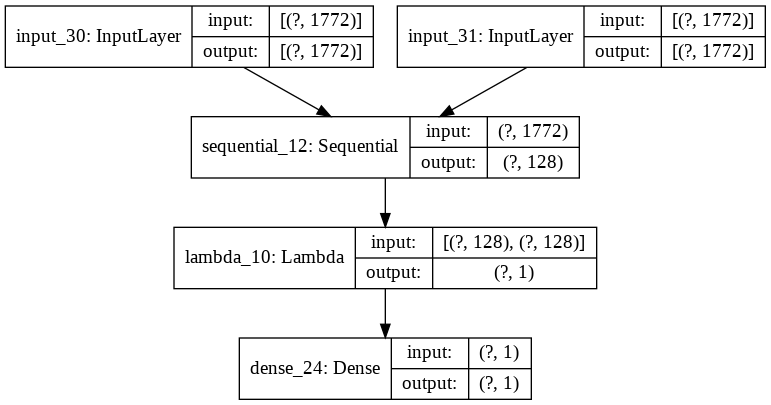

In [0]:
tf.keras.utils.plot_model(model, 'siamese network.png', show_shapes=True)

In [0]:
model.fit([train1_padded[:500], train2_padded[:500]], labels[:500],epochs=33, validation_data=([test1_padded[:50], test2_padded[:50]], val_label[:50]))

Epoch 1/33
16/16 [==============================] - 213s 13s/step - loss: 3.1996 - accuracy: 0.5040 - val_loss: 1.9281 - val_accuracy: 0.5200
Epoch 2/33
16/16 [==============================] - 209s 13s/step - loss: 1.3608 - accuracy: 0.5040 - val_loss: 1.8258 - val_accuracy: 0.5200
Epoch 3/33
 7/16 [============>.................] - ETA: 1:44 - loss: 1.2985 - accuracy: 0.4732

KeyboardInterrupt: ignored

In [0]:
n_hidden = 50
gradient_clipping_norm  = 1.25
# what is gradient clipping norm?
# https://www.quora.com/What-is-gradient-clipping-and-why-is-it-necessary

batch_size = 64
n_epoch = 3
from keras import backend as K


def exponent_neg_manhattan_distance(left, right):
  return K.exp(-K.sum(K.abs(left-right),axis = 1, keepdims = True))

# a. input layer
left_input = tf.keras.Input(shape=(max_length,), dtype="int32")
right_input = tf.keras.Input(shape=(max_length,), dtype="int32")

# b. embedding layer
embedding_layer = tf.keras.layers.Embedding(
    input_dim = vocab_size, # size of the vocabulary, len( a matrix) will 
    # only return its first dimension length. The shape of the embedding matrix is
    # input_dim, output_dim
    
    output_dim = 300, # 
    weights= [embedding_mat], # there is not weights in Embedding api
    # https://keras.io/layers/embeddings/
    # but there are examples using pretrained word2vec in the blog below:
    # https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
    input_length=max_length,
    trainable=False)
# https://keras.io/layers/embeddings/

encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

#
shared_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

malstm_distance = tf.keras.layers.Lambda(lambda x:exponent_neg_manhattan_distance(x[0],x[1]), 
                        output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
# several exampls about Merge
# https://statcompute.wordpress.com/2017/01/08/an-example-of-merge-layer-in-keras/

malstm = tf.keras.Model([left_input, right_input], [malstm_distance])
malstm.summary()


Using TensorFlow backend.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2164)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2164)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 2164, 300)    30000000    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256)          439296      embedding[0][0]              

In [0]:
optimizer = tf.keras.optimizers.Adadelta(clipnorm = 1.25)
malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])


In [0]:
labels.shape

(32000,)

In [0]:

# from keras.callbacks import TensorBoard
# tensorboard = TensorBoard(log_dir=LOG_DIR.format(time()))


# malstm_trained = malstm.fit([train1_padded[:500], train2_padded[:500]], labels[:500], batch_size=batch_size, nb_epoch=n_epoch,
#                             validation_data=([test1_padded[:50], test2_padded[:50]], val_label[:50]))

malstm_trained = malstm.fit([train1_padded, train2_padded], labels, epochs=3, batch_size=32,
                            validation_data=([test1_padded, test2_padded], val_label))




Epoch 1/3
1000/1000 [==============================] - 6521s 7s/step - loss: 0.4607 - accuracy: 0.4979 - val_loss: 0.4505 - val_accuracy: 0.5104
Epoch 2/3
1000/1000 [==============================] - 6522s 7s/step - loss: 0.4602 - accuracy: 0.4980 - val_loss: 0.4500 - val_accuracy: 0.5102
Epoch 3/3
 362/1000 [=========>....................] - ETA: 1:04:04 - loss: 0.4581 - accuracy: 0.5008

KeyboardInterrupt: ignored